In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

Names and PRN for all group members:
- Name: ______________________
- PRN:  ______________________
- Date: ______________________

# Deep Neural Networks
## A07: Group Assignment


##  Convolutional Neural Network (CNN)

- Flowers Dataset


In [47]:
###-----------------
### Import Libraries
###-----------------

#!/usr/bin/env pyhton3
# -*- coding 

from sklearn import datasets
from sklearn.model_selection import train_test_split
###-----------------
### Import Libraries
###-----------------
import os
import time
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix
import gc
import torch.nn as nn
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns
import tensorflow as tf
from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix,fn_plot_label
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [49]:
###----------------------
### Some basic parameters
###----------------------
# Global variables
inpDir = './input' # Input Stored here
outDir = './ouput' # output Here
modelDir = './models'# to save Models
subDir = 'flower_photos' # sub dir by dataset
altName = 'base_model'
RANDOM_STATE = 24
np.random.RandomState(seed = RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
#rng = np.random.default_rng(seed = RANDOM_STATE)
#N_SAMPLE = 1000
TEST_SIZE = 0.2 # 18147 - 56*256
ALPHA = 0.001 # learning rate
NOISE = 0.2 # Error
EPOCHS = 30
BATCH_SIZE = 16

PATIENCE = 15
LR_FACTOR  =0.1
LR_PATIENCE = 20
IMG_HEIGHT = 188
IMG_WIDTH = 188

In [51]:
#set the plotting parameters
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'
         }
    #'text.usetex':True,

plt.rcParams.update(params)
CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid')


## Load Dataset

Images are under flower_photos

     |- daisy
     |- dandelion
     |- roses
     |- sunflowers
     |- tulips

In [54]:
'''
    For reading from web link
'''

#import pathlib
#dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
#data_dir = tf.keras.utils.get_file(origin=dataset_url,
#                                   fname='flower_photos',
#                                   untar=True)
#data_dir = pathlib.Path(data_dir)
'''
    For reading from local directory
'''
data_dir = os.path.join(inpDir, subDir)

In [56]:
data_dir

'./input\\flower_photos'

In [58]:
os.listdir(data_dir)

['daisy', 'dandelion', 'LICENSE.txt', 'roses', 'sunflowers', 'tulips']

In [60]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
     data_dir, 
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT,IMG_WIDTH),
    subset='training',
    seed = RANDOM_STATE,
    validation_split=TEST_SIZE,
   
    
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [61]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
     data_dir, 
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT,IMG_WIDTH),
    subset='validation',
    seed = RANDOM_STATE,
    validation_split=TEST_SIZE,
   
    
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [62]:
#Is it getting the class names

class_names = train_ds.class_names
num_classes = len(class_names)
display(class_names, num_classes)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

5

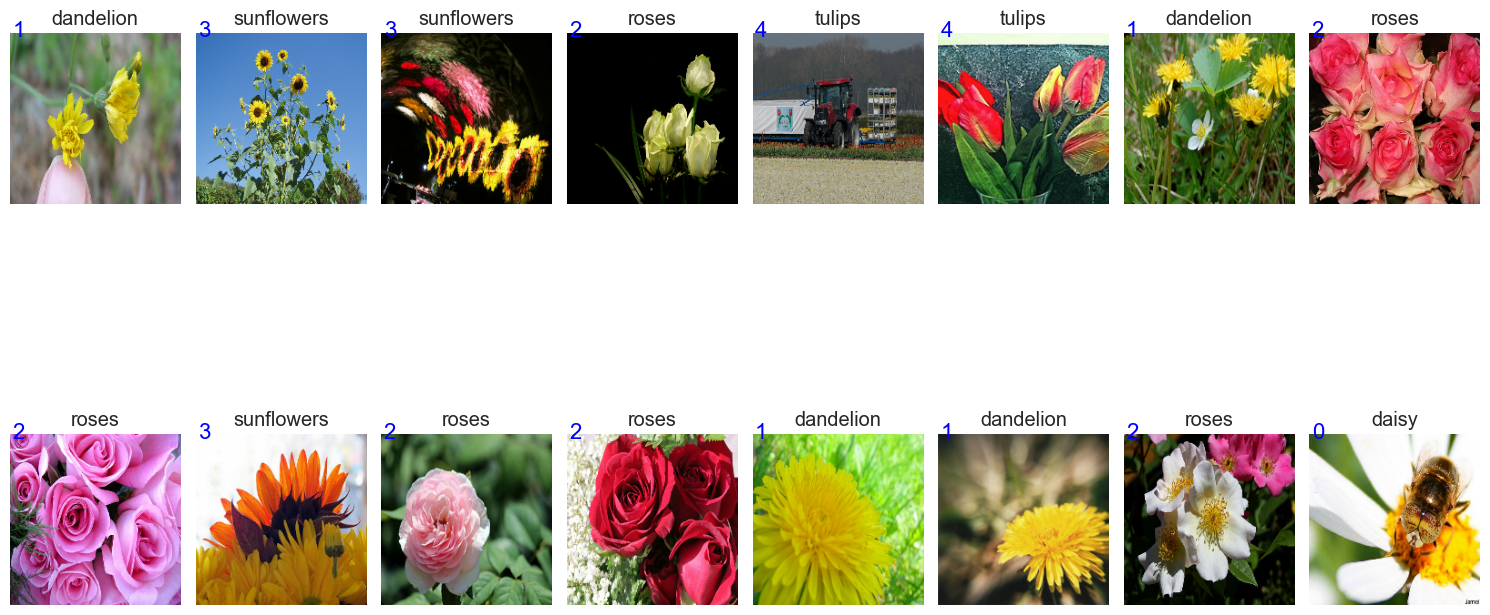

In [64]:
# sample DATA plot: Display a grid of images from the dataset along with their labels



#create a new figure for the grid of images with a specified size
fig = plt.figure(figsize  =(15,12))

#Adjust Margins
fig.subplots_adjust(left = 0, right = 1, bottom=0, top = 1, hspace =0.05, wspace = 0.05)
i= 0 
for images, labels in train_ds.take(1):
    for i in range(BATCH_SIZE):
        plt.subplot(BATCH_SIZE// 8,8, i+1)
        plt.grid(False)

        plt.imshow(images[i].numpy().astype('uint8'), cmap = plt.cm.binary)
        
        # Add the numeric label to the image in blue text at a specific position
        plt.title(class_names[labels[i].numpy()])
        
        
        # Add the class name of the image in red text below the numeric label 
        plt.text(2,4, labels[i].numpy(), color = 'b', fontsize=16)
    #SWITCH OF AXIS   
        plt.axis('off')
plt.tight_layout()
#Display the entire frid of images
plt.show()

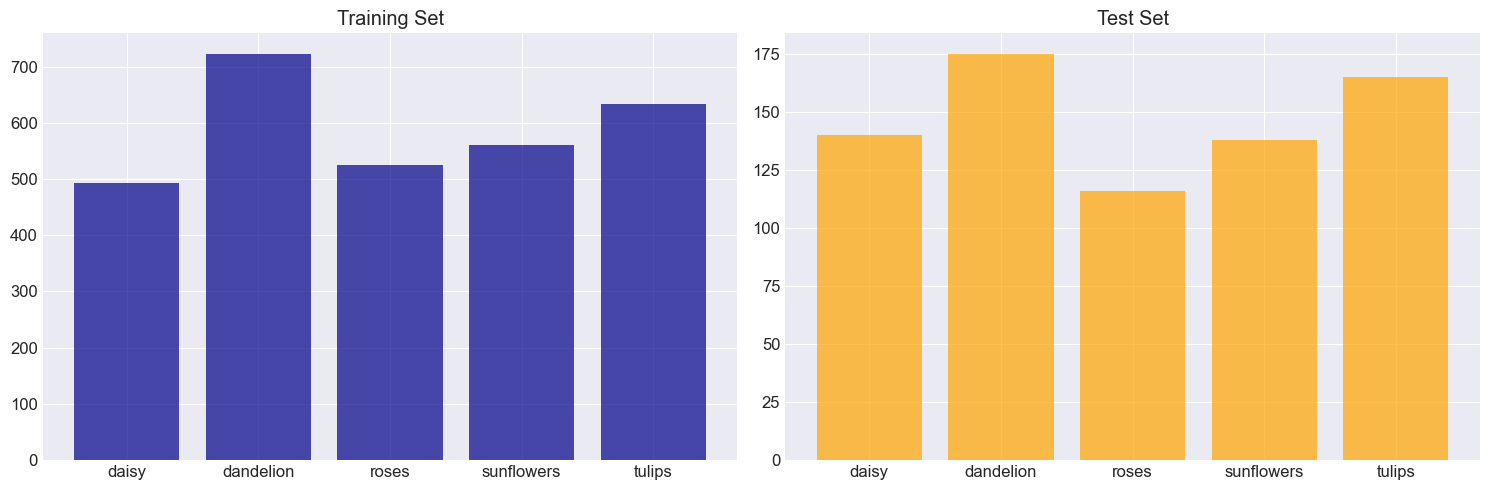

In [66]:
fn_plot_label(train_ds, test_ds)

In [69]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
input_shape

(188, 188, 3)

## Data Augmentation 

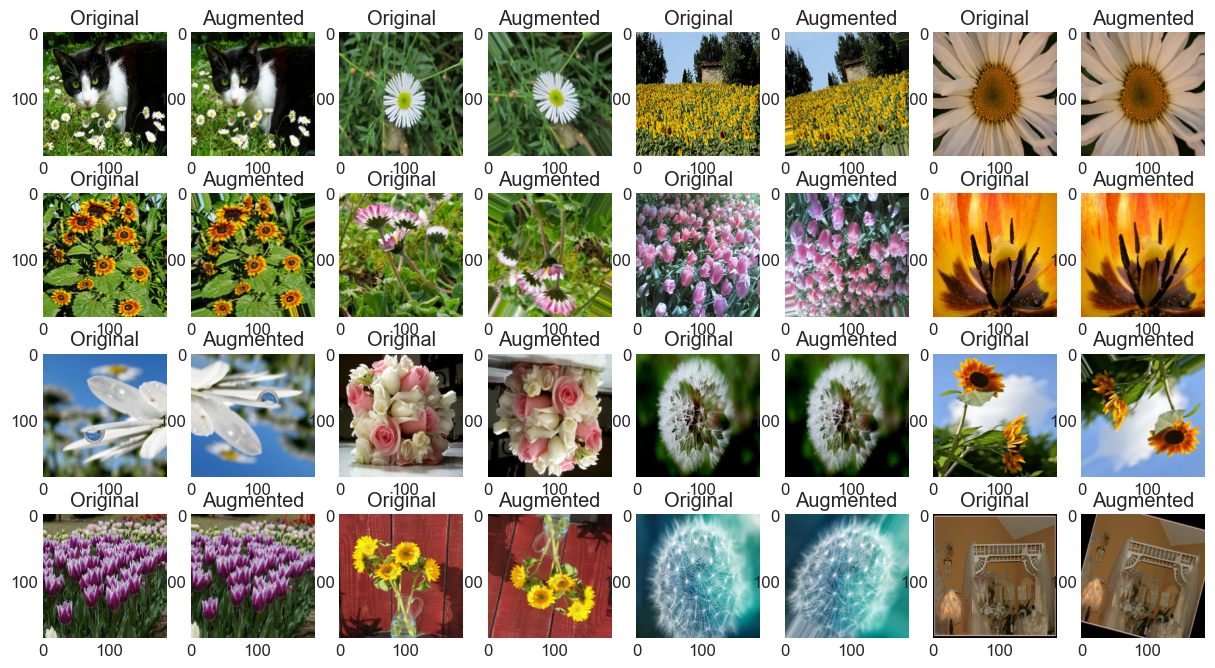

In [71]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),  # Flip images randomly
    tf.keras.layers.RandomRotation(0.1,
                                  fill_mode='nearest'),                   # Rotate images by up to 20%
    #tf.keras.layers.RandomZoom(0.2),                       # Zoom in/out randomly
    #tf.keras.layers.RandomContrast(0.1)                    # Adjust contrast
])
plt.figure()


for i, data in enumerate(train_ds.take(16)):
    imgs, lbls = data
    out_images = data_augmentation(imgs)
    plt.subplot(4,8,2*i+1)
    plt.title('Original')
    plt.grid(False)
    plt.imshow(imgs[i].numpy().astype('uint8'))
    plt.subplot(4,8,2*i+2)
    plt.title('Augmented')
    plt.imshow(out_images[i].numpy().astype('uint8'))
    plt.grid(False)

In [72]:
train_ds = train_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

In [73]:
krnl_initializer =tf.keras.initializers.GlorotUniform(seed = RANDOM_STATE)
#krnl_reg = None
#tf.keras.regularizers.L2(l2=0.01)




#Dropout
dor0 = 0.0
dor1 = 0.1
dor2 = 0.2
dor3 = 0.3
dor4 = 0.4
dor5 = 0.5

inputs = tf.keras.Input(shape = input_shape, name = 'input')

x = data_augmentation(inputs)# Data Augmentation

x = tf.keras.layers.Rescaling(1./255.)(x)


##....
#Set1
#conv

x = tf.keras.layers.Conv2D(64, (3,3), kernel_initializer=krnl_initializer,
                           


                          padding='same',

                         name = 'conv_1')(x) #o/p (188,188,64)
#batch norm
x = tf.keras.layers.BatchNormalization()(x)
#activation
x = tf.keras.layers.ReLU()(x)
#Dropout layer
#x = tf.keras.layers.Dropout(dor1)(x)

# MAxpool
x = tf.keras.layers.MaxPool2D((2,2), name='mp_1')(x) #o/p (94,94,64)



##....
#Set2
#conv

x = tf.keras.layers.Conv2D(128, (3,3), kernel_initializer=krnl_initializer,
                          
                         name = 'conv_2')(x) #o/p (92,92,128)
#batch norm
x = tf.keras.layers.BatchNormalization()(x)
#activation
x = tf.keras.layers.ReLU()(x)
#Dropout layer
#x = tf.keras.layers.Dropout(dor)(x)

# MAxpool
x = tf.keras.layers.MaxPool2D((2,2), name='mp_2')(x) #o/p (46,46,128)



##....
#Set3
#conv

x = tf.keras.layers.Conv2D(256, (3,3), kernel_initializer=krnl_initializer,
                           

                         name = 'conv_3')(x) #o/p (44,44,256)
#batch norm
x = tf.keras.layers.BatchNormalization()(x)
#activation
x = tf.keras.layers.ReLU()(x)
#Dropout layer
#x = tf.keras.layers.Dropout(dor3)(x)

# MAxpool
x = tf.keras.layers.MaxPool2D((2,2), name='mp_3')(x) #o/p (22,22,256)



##....
#Set4
#conv

x = tf.keras.layers.Conv2D(512, (3,3), kernel_initializer=krnl_initializer,
                          

                         name = 'conv_4')(x) #o/p (20,20,512)
#batch norm
x = tf.keras.layers.BatchNormalization()(x)
#activation
x = tf.keras.layers.ReLU()(x)
#Dropout layer
#x = tf.keras.layers.Dropout(dor3)(x)

# MAxpool
x = tf.keras.layers.MaxPool2D((2,2), name='mp_4')(x) #o/p (10,10,512)

#Set5
#conv

x = tf.keras.layers.Conv2D(1024, (3,3), kernel_initializer=krnl_initializer,
                          

                          name = 'conv_5')(x) #o/p (8,8,1024)

#batch norm
x = tf.keras.layers.BatchNormalization()(x)
#activation
x = tf.keras.layers.ReLU()(x)
#Dropout layer
#x = tf.keras.layers.Dropout(dor3)(x)



# MAxpool
x = tf.keras.layers.MaxPool2D((2,2), name='mp_5')(x) #o/p (4,4,1024)


#Set6
#conv

x = tf.keras.layers.Conv2D(2048, (3,3), kernel_initializer=krnl_initializer,
                           
                          name = 'conv_6')(x) #o/p (2,2,2048)

#batch norm
x = tf.keras.layers.BatchNormalization()(x)
#activation
x = tf.keras.layers.ReLU()(x)
#Dropout layer
#x = tf.keras.layers.Dropout(dor2)(x)


x = tf.keras.layers.Flatten()(x)


x = tf.keras.layers.Dense(1024,activation=tf.keras.activations.relu,
                         

                         name = 'fc_1')(x)
#batch norm
x = tf.keras.layers.BatchNormalization()(x)
#activation
x = tf.keras.layers.ReLU()(x)
#Dropout layer
#x = tf.keras.layers.Dropout(dor1)(x)

outputs = tf.keras.layers.Dense(5,
                                activation='softmax',
                               name = 'output')(x)

model = tf.keras.Model(inputs = inputs, outputs = outputs, name = 'Flowers')
model.summary()





TypeError: 'KerasTensor' object is not callable

## Model

In [21]:
# krnl_initializer =tf.keras.initializers.GlorotUniform(seed = RANDOM_STATE)
# krnl_reg = None
# #tf.keras.regularizers.L2(l2=0.01)




# #Dropout
# dor1 = 0.1
# dor2 = 0.2
# dor3 = 0.3
# dor4 = 0.4

# inputs = tf.keras.Input(shape = input_shape, name = 'input')
# x = tf.keras.layers.Rescaling(1./255.)(inputs)


# ##....
# #Set1
# #conv

# x = tf.keras.layers.Conv2D(64, (3,3), kernel_initializer=krnl_initializer,
#                            #kernel_regularizer= krnl_reg,
#                           padding='same',
#                           activation=tf.keras.activations.relu,
#                          name = 'conv_1')(x) #o/p (188,188,64)
# #batch norm
# #x = tf.keras.layers.BatchNormalization()(x)
# #activation
# x = tf.keras.layers.ReLU()(x)
# #Dropout layer
# #x = tf.keras.layers.Dropout(dor1)(x)

# # MAxpool
# x = tf.keras.layers.MaxPool2D((2,2), name='mp_1')(x) #o/p (94,94,64)



# ##....
# #Set2
# #conv

# x = tf.keras.layers.Conv2D(128, (3,3), kernel_initializer=krnl_initializer,
#                            #kernel_regularizer= krnl_reg,
                          
#                           activation=tf.keras.activations.relu,
#                          name = 'conv_2')(x) #o/p (92,92,128)
# #batch norm
# #x = tf.keras.layers.BatchNormalization()(x)
# #activation
# x = tf.keras.layers.ReLU()(x)
# #Dropout layer
# #x = tf.keras.layers.Dropout(dor1)(x)

# # MAxpool
# x = tf.keras.layers.MaxPool2D((2,2), name='mp_2')(x) #o/p (46,46,128)



# ##....
# #Set3
# #conv

# x = tf.keras.layers.Conv2D(256, (3,3), kernel_initializer=krnl_initializer,
#                            #kernel_regularizer= krnl_reg,
                          
#                           activation=tf.keras.activations.relu,
#                          name = 'conv_3')(x) #o/p (44,44,256)
# #batch norm
# #x = tf.keras.layers.BatchNormalization()(x)
# #activation
# x = tf.keras.layers.ReLU()(x)
# #Dropout layer
# #x = tf.keras.layers.Dropout(dor1)(x)

# # MAxpool
# x = tf.keras.layers.MaxPool2D((2,2), name='mp_3')(x) #o/p (22,22,256)



# ##....
# #Set4
# #conv

# x = tf.keras.layers.Conv2D(512, (3,3), kernel_initializer=krnl_initializer,
#                            #kernel_regularizer= krnl_reg,
                          
#                           activation=tf.keras.activations.relu,
#                          name = 'conv_4')(x) #o/p (20,20,512)
# #batch norm
# #x = tf.keras.layers.BatchNormalization()(x)
# #activation
# x = tf.keras.layers.ReLU()(x)
# #Dropout layer
# #x = tf.keras.layers.Dropout(dor1)(x)

# # MAxpool
# x = tf.keras.layers.MaxPool2D((2,2), name='mp_4')(x) #o/p (10,10,512)

# #Set5
# #conv

# x = tf.keras.layers.Conv2D(1024, (3,3), kernel_initializer=krnl_initializer,
#                             kernel_regularizer= krnl_reg,
                          
#                           activation=tf.keras.activations.relu,
#                           name = 'conv_5')(x) #o/p (8,8,1024)

# #batch norm
# #x = tf.keras.layers.BatchNormalization()(x)
# #activation
# x = tf.keras.layers.ReLU()(x)
# #Dropout layer
# #x = tf.keras.layers.Dropout(dor2)(x)



# # MAxpool
# x = tf.keras.layers.MaxPool2D((2,2), name='mp_5')(x) #o/p (4,4,1024)


# #Set6
# #conv

# x = tf.keras.layers.Conv2D(2048, (3,3), kernel_initializer=krnl_initializer,
#                             kernel_regularizer= krnl_reg,
                          
#                           activation=tf.keras.activations.relu,
#                           name = 'conv_6')(x) #o/p (2,2,2048)

# #batch norm
# #x = tf.keras.layers.BatchNormalization()(x)
# #activation
# x = tf.keras.layers.ReLU()(x)
# #Dropout layer
# #x = tf.keras.layers.Dropout(dor3)(x)


# x = tf.keras.layers.Flatten()(x)


# x = tf.keras.layers.Dense(1024,activation=tf.keras.activations.relu,
#                           kernel_regularizer = krnl_reg,
#                          name = 'fc_1')(x)
# #batch norm
# #x = tf.keras.layers.BatchNormalization()(x)
# #activation
# x = tf.keras.layers.ReLU()(x)
# #Dropout layer
# #x = tf.keras.layers.Dropout(dor4)(x)

# outputs = tf.keras.layers.Dense(5,
#                                name = 'output')(x)

# model = tf.keras.Model(inputs = inputs, outputs = outputs, name = 'Flowers')
# model.summary()





Model: "Flowers"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 188, 188, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 188, 188, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv2D)                      │ (None, 188, 188, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 188, 188, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mp_1 (MaxPooling2D)                  │ (None, 94, 94, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, 92, 92, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 92, 92, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mp_2 (MaxPooling2D)                  │ (None, 46, 46, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_3 (Conv2D)                      │ (None, 44, 44, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 44, 44, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mp_3 (MaxPooling2D)                  │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_4 (Conv2D)                      │ (None, 20, 20, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 20, 20, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mp_4 (MaxPooling2D)                  │ (None, 10, 10, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_5 (Conv2D)                      │ (None, 8, 8, 1024)          │       4,719,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_4 (ReLU)                       │ (None, 8, 8, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mp_5 (MaxPooling2D)                  │ (None, 4, 4, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_6 (Conv2D)                      │ (None, 2, 2, 2048)          │      18,876,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_5 (ReLU)                       │ (None, 2, 2, 2048)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 1024)                │       8,389,632 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 33,541,765 (127.95 MB)

 Trainable params: 33,541,765 (127.95 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

optimizer = tf.keras.optimizers.Adam(learning_rate = ALPHA)

model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [23]:
chkptFilePath = os.path.join(modelDir, subDir, f'{altName}.weights.h5')
PATIENCE = 30

mcb = tf.keras.callbacks.ModelCheckpoint(chkptFilePath,
                                        monitor = 'val_loss',
                                        verbose = 1,
                                        save_best_only = True,
                                        save_weights_only = True)

escb = tf.keras.callbacks.EarlyStopping(patience = PATIENCE,
                                       verbose = 1,
                                       restore_best_weights = True)

lrcb = tf.keras.callbacks.ReduceLROnPlateau(factor = LR_FACTOR,
                                           patience = LR_PATIENCE,
                                           verbose = 1)

In [24]:

history = model.fit(train_ds, epochs=EPOCHS,
                    callbacks = [mcb, escb, lrcb],
                    validation_data=test_ds,
                   verbose = 1)

# results and inferences
hist_df = pd.DataFrame(history.history) 

display(hist_df.head(3))
display(hist_df.tail(3))



Epoch 1/30
 65/184 ━━━━━━━━━━━━━━━━━━━━ 2:21 1s/step - accuracy: 0.1993 - loss: 1.8582

AbortedError: Graph execution error:

Detected at node StatefulPartitionedCall/Flowers_1/conv_6_1/Relu defined at (most recent call last):
<stack traces unavailable>
Operation received an exception:Status: 1, message: could not create a memory object, in file tensorflow/core/kernels/mkl/mkl_conv_ops.cc:1112
	 [[{{node StatefulPartitionedCall/Flowers_1/conv_6_1/Relu}}]] [Op:__inference_one_step_on_iterator_3950]

In [ ]:
fn_plot_tf_hist(hist_df = hist_df)


### Evaluate the model

## Validate on the validation set